In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns

from theano import shared

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
sns.set(context='notebook', font_scale=1.2, rc={'figure.figsize': (12, 5)})
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

RANDOM_SEED = 8927
np.random.seed(286)

### 11E1.
*What is the difference between an ordered categorical variable and an unordered one? Define and then give an example of each.*

- *Unordered categorical variable*: a variable that has distinct and discrete outcomes, which do not present any particular order. For example, imagine that you record customers' choice of crêpes on the *Pont des Arts* in Paris. Your outcome variable could have four distinct categories - sugar, marmelade, salted caramel and, of course, Nutella - but these categories do not have inherent ordering (though who would choose sugar when you can have Nutella??). These variables are the natural extension of binary outcomes to more than two categories. Other examples include choices among colors, individual identities, and individual words.

- *Ordered categorical variable*: a variable that has distinct and discrete outcomes, which have an inherent order. There your outcome variable could be the scale on which you like Nutella on your crêpe - 1 to 10 for example. Note that the distances between the values are not necessarily the same. So for example the amount of change required to move a value from 1 to 2 may be different from the amount of change required to move from 2 to 3. Other examples include subjective ratings, “Likert” scales, and relative distances or durations.

### 11E2.
*What kind of link function does an ordered logistic regression employ? How does it differ from an ordinary logit link?*

The conventional link is the cumulative logit link function. The cumulative probability of a value is the probability of that value or any smaller value. In simple logistic regressions, the linear model is defined on the log-odds scale. In *ordered* logistic regression, the linear model is defined on the log-cumulative-odds scale.

### 11E3.
*When count data are zero-inflated, using a model that ignores zero-inflation will tend to induce which kind of inferential error?*

Ignoring zero-in ation will tend to underestimate the rate of events. Why? Because a count distribution with extra zeros added to it will have a lower mean. So treating such data as single-process count data will result in a lower estimate for the mean rate.

### 11E4.
*Over-dispersion is common in count data. Give an example of a natural process that might produce over-dispersed counts. Can you also give an example of a process that might produce under-dispersed counts?*

Over-dispersioncanarisesimplyfromvariationinunderlyingratesacrossunits.Forexample, if we count the number of ice creams sold by various ice cream shops for each day over an entire month, the aggregated counts will likely be over-dispersed.  is is because some shops sell more ice cream than others—they do not all have the same average rate of sales across days.

Under-dispersion is considered less o en. Under-dispersed count data has less variation than expected. One common process that might produce under-dispersed counts is when sequential ob- servations are directly correlated with one another, autocorrelation.  is is the premise of Conway- Maxwell-Poisson (aka COM-Poisson) distributions, which arise from one model of this kind, the state-dependent queuing model, commonplace in the study of servers and production systems of many kinds. Simply stated, when the rate at which jobs are completed depends upon how many jobs are waiting to be completed, then counts may be highly autocorrelated.  is reduces variation in the observed counts, resulting in under-dispersion.

### 11M1.
*At a certain university, employees are annually rated from 1 to 4 on their productivity, with 1 being least productive and 4 most productive. In a certain department at this certain university in a certain year, the number of employees receiving each rating were (from 1 to 4): 12, 36, 7, 41. Compute the log-cumulative-odds of each rating.*

In [2]:
hist = pd.DataFrame(index=[1, 2, 3, 4], columns=["counts"], data=[12, 36, 7, 41])
hist.index.name = "rating"

# proportion of each rating
props = hist / hist.sum()

# cumulative proportions of ratings
cum_props = props.cumsum()

# turn into odds and take the log, thanks to logit (hence cumulative logit)
sp.special.logit(cum_props)

,counts
rating,
1,-1.945910
2,0.000000
3,0.293761
4,inf


### 11M2.
*Make a version of figure 11.2 for the employee ratings data given just above.*

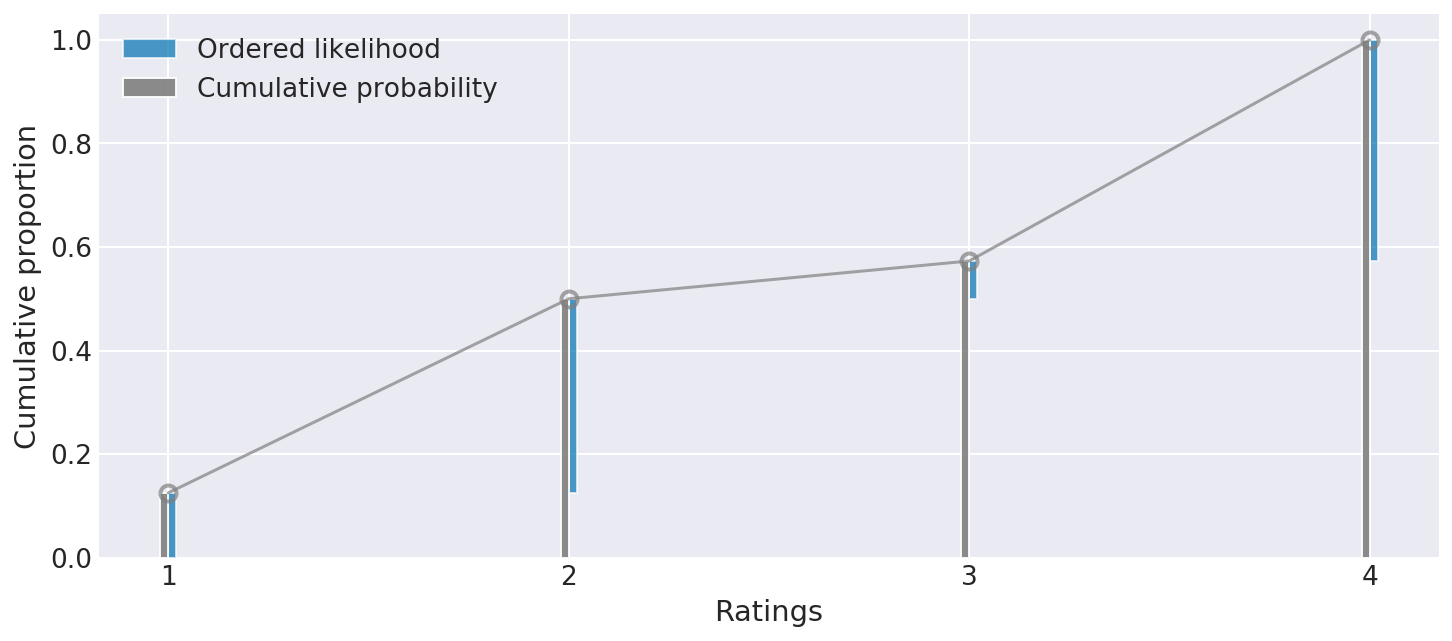

In [17]:
plt.figure(figsize=(12,5))
plt.bar(cum_props.index + .01, props.counts, bottom=pd.Series(0).append(cum_props.counts.iloc[:-1]), 
        width=.02, alpha=.7, label="Ordered likelihood")
plt.bar(cum_props.index - .01, cum_props.counts, width=.02, color="gray", alpha=.9, label="Cumulative probability")
plt.plot(cum_props.index, cum_props.counts, "-o", fillstyle="none", ms=8, markeredgewidth=2, color="gray", alpha=.7, label="")
plt.xticks(cum_props.index)
plt.xlabel("Ratings")
plt.ylabel("Cumulative proportion")
plt.legend();

### 11M3.
*Can you modify the derivation of the zero-inflated Poisson distribution (ZIPoisson) from the chapter to construct a zero-inflated binomial distribution?*

As with the zero-inflated Poisson, the zero-inflated binomial mixes some extra zeros into another distribution. The structure is very much the same as the ZIPoisson. First, a single probability determines whether or not a zero is observed. Call this probability $p_{0}$. When a zero is not observed from this first process, the binomial distribution takes over. It may also generate a zero. Call the probability of a success from the binomial process $q$, and let it have n trials. Then the probability of a zero, mixing together both processes, is:

$Pr(0|p_{0}, q, n) = p_{0} + (1 - p_{0})(1 - q)^n$

The logic is that either we get a zero from the first process, $p_{0}$ of the time, or we get a zero from the binomial, which happens only when all trials fail, $(1 − q)^n$ of the time. The probability of any particular non-zero observation $y$ is similarly:

$Pr(y|p_{0}, q, n) = (1 - p_{0})\frac{n!}{y!(n-y)!}q^y(1 - q)^{n-y}$

Compare this expression to the ZIPoisson expression in the chapter.

### 11H1.
*In 2014, a paper was published that was entitled "Female hurricanes are deadlier than male hurricanes". As the title suggests, the paper claimed that hurricanes with female names have caused greater loss of life, and the explanation given is that people unconsciously rate female hurricanes as less dangerous and so are less likely to evacuate.*

*Statisticians severly critized the paper after publication. Here, you'll explore the complete data used in the paper and consider the hypothesis that hurricanes with female names are deadlier.*

In [35]:
hurricanes = pd.read_csv("../Data/hurricanes.csv", sep=";")
# Standardize predictor, as usual
hurricanes["femininity"] = (hurricanes["femininity"] - hurricanes["femininity"].mean())/hurricanes["femininity"].std()
hurricanes.tail()

,name,year,deaths,category,min_pressure,damage_norm,female,femininity
87,Gustav,2008,52,2,954,4360,0,-1.567471
88,Ike,2008,84,2,950,20370,0,-1.515826
89,Irene,2011,41,1,952,7110,1,0.773725
90,Isaac,2012,5,1,966,24000,0,-1.498613
91,Sandy,2012,159,2,942,75000,1,0.687651


In [36]:
hurricanes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 8 columns):
name            92 non-null object
year            92 non-null int64
deaths          92 non-null int64
category        92 non-null int64
min_pressure    92 non-null int64
damage_norm     92 non-null int64
female          92 non-null int64
femininity      92 non-null float64
dtypes: float64(1), int64(6), object(1)
memory usage: 5.8+ KB


*In this problem, you'll focus on predicting deaths using feminity of each hurricane's name. Fit and interpret the simplest possible model: a Poisson model of deaths using feminity as a predictor.*

*Compare the model to an intercept-only Poisson model of deaths. How strong is the association between femininity of name and deaths? Which storms does the model fit (retrodict) well? Which storms does it fir poorly?*

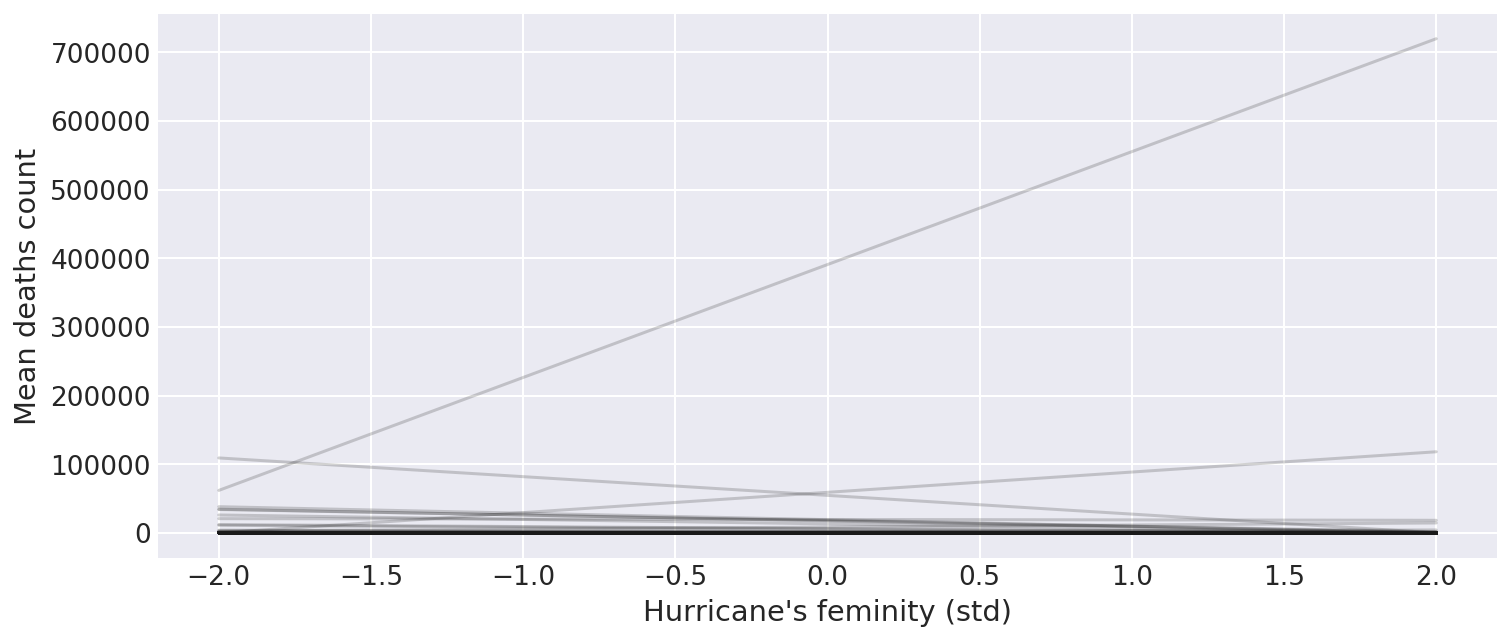

In [50]:
# Prior predictive checks, to see if prior choice makes sense
a_s = pm.Normal.dist(mu=0., sd=4.5).random(size=200)
bf_s = pm.Normal.dist(mu=0., sd=.8).random(size=200)

plt.figure(figsize=(12,5))
for y_s in zip(np.exp(a_s - 2*bf_s), np.exp(a_s + 2*bf_s)):
    plt.plot([-2, 2], y_s, color='k', alpha=.2)
plt.xlabel("Hurricane's feminity (std)")
plt.ylabel("Mean deaths count");

In [51]:
with pm.Model() as model_feminity:
    # The exp link makes the lambda really big, really quickly, so need strongly regularizing priors:
    a = pm.Normal('a', 0., 4.5)
    bf = pm.Normal('bf', 0., .8)
    lam = pm.math.exp(a + bf*hurricanes.femininity)
    
    deaths = pm.Poisson('deaths', mu=lam, observed=hurricanes.deaths)

    trace_feminity = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

post_fem = pm.trace_to_dataframe(trace_feminity)
pm.summary(trace_feminity, alpha=0.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bf, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:09<00:00, 557.28draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,3.00,0.02,0.0,2.96,3.04,1657.99,1.0
bf,0.24,0.03,0.0,0.20,0.28,1767.52,1.0


So this model seems to think there is a reliably positive association between femininity of the hurricanes names and deaths.

In [52]:
with pm.Model() as model_itcpt:
    a = pm.Normal('a', 0., 4.5)
    
    deaths = pm.Poisson('deaths', mu=pm.math.exp(a), observed=hurricanes.deaths)

    trace_itcpt = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

post_itcpt = pm.trace_to_dataframe(trace_itcpt)
pm.summary(trace_itcpt, alpha=0.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:07<00:00, 831.92draws/s] 
The acceptance probability does not match the target. It is 0.8862156745233059, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,3.03,0.02,0.0,2.99,3.06,718.0,1.0


/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:1014: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:1014: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


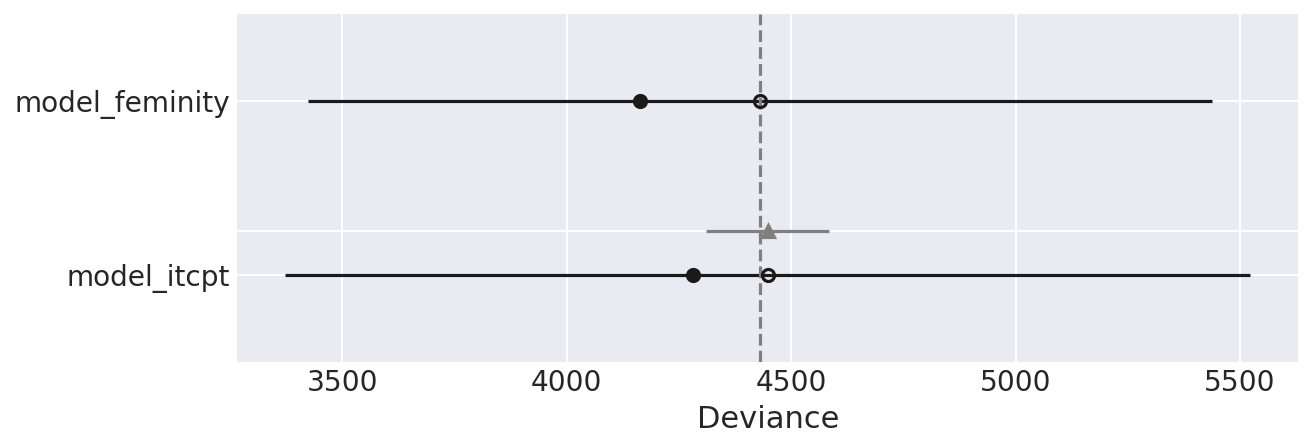

In [53]:
comp_df = az.compare({"model_itcpt": trace_itcpt, "model_feminity": trace_feminity})
az.plot_compare(comp_df, figsize=(9,3));

So the femininity model does not look to perform better out-of-sample than the incercept-only model: the difference in WAIC is quite low and, more importantly, is dwarfed by the standard error of that difference. Note that the standard error of both model is huge.

Now in order to see which hurricanes the model retrodicts well, we can plot the implied trend over the raw data points. We’ll compute and plot the expected death count, 89% interval of the expectation and 89% interval of the expected distribution of deaths (using Poisson sampling).

In [55]:
np.exp(0.24)

1.2712491503214047

In [57]:
comp_df

,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_feminity,4429.46,133.345,0,0.469548,1006.93,0,1,deviance
model_itcpt,4447.8,83.1401,18.3472,0.530452,1074.57,137.124,1,deviance
